# Exercise 4: Neural Network Learning

In this exercise, we first implement feedforward propagation for neural network with the already given weights and then We will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. 

In [204]:
# importing the important Libraries

# Used for computations of numerical data.
import numpy as np

# Used for reading data and data manipulation
import pandas as pd 

# Used for graphing data.
import matplotlib.pyplot as plt

# Used to load the OCTAVE *.mat files
from scipy.io import loadmat
import scipy.optimize as opt

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# ===== Part 1: Loading and Visualizing Data =====

In [205]:
data = loadmat('C:\\Users\\nomaniqbal\\Downloads\\notebook\\HomeworkMl\\mlclass-ex4-jin\\ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [206]:
X = data['X']
y = data['y']

X.shape, y.shape

((5000, 400), (5000, 1))

Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.  
Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image. The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.  

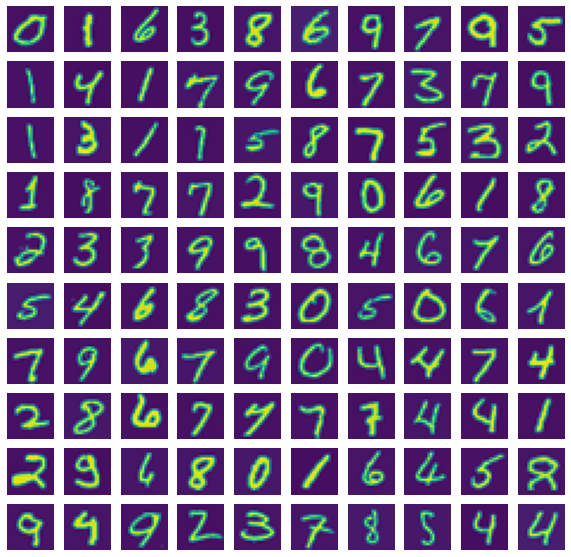

In [207]:
# visualizing the data

# plt.subplots() is a function that returns a tuple containing a figure and axes object(s). 
# Thus when using fig, ax = plt.subplots() you unpack this tuple into the variables fig and ax. 
# Having fig is useful if you want to change figure-level attribute or save the figure as an image file later
# (e.g. with fig.savefig('yourfilename.png')). 
# The first two optional arguments of pyplot.subplots define the number of rows and columns(10,10) of the subplot grid.

_, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(X[np.random.randint(X.shape[0])].\
reshape((20,20), order = 'F'))          
        axarr[i,j].axis('off')

In [208]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


# ===== Part 2: Loading Parameters =====

### Model representation

Our neural network has 3 layers — an input layer, a hidden layer and an output layer. Do recall that the inputs will be 20 x 20 grey scale images "unrolled" to form 400 input features which we will feed into the neural network. So our input layer has 400 neurons. Also the hidden layer has 25 neurons and the output layer 10 neurons corresponding to 10 digits (or classes) our model predicts.  
We have been provided with a set of already trained network parameters. These are stored in ex4weights.mat and will be loaded into theta1 and theta2 followed by unrolling into a vector nn_params. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [209]:
# we have been provided with a set of network parameters (Θ(1),Θ(2)) 
# already trained. These are stored in ex4weights.mat
weights = loadmat('C:\\Users\\nomaniqbal\\Downloads\\notebook\\HomeworkMl\\mlclass-ex4-jin\\ex4weights.mat')
weights

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Theta1': array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
         -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
        [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
         -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
        [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
         -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
        ...,
        [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
          2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
        [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
         -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
        [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
         -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.057781

In [210]:
theta1 = weights['Theta1']    #Theta1 has size 25 x 401
theta2 = weights['Theta2']    #Theta2 has size 10 x 26
nn_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F')))    #unroll parameters

# Initialize settings
# neural network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1
theta1

array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
        -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
       [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
        -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
       [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
        -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
       ...,
       [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
         2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
       [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
        -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
       [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
        -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]])

# ===== Part 3: Compute Cost (Feedforward) =====

First we will implement the cost function followed by gradient for the neural network (for which we use backpropagation algorithm). Recall that the cost function for the neural network with regularization is  
$J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right]$  
K = 10 is the total number of possible labels. Note that h(x(i)) = a(3) is the activations of the output units. Also, whereas the original labels (in the variable y) were 1, 2, …, 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1. for this purphose we will use one-hot encoding. 
It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature. One-Hot Encoding is the process of creating dummy variables.  
For example, if x(i) is an image of the digit 5, then the corresponding y(i)(that you should use with the cost function) should be a 10-dimensional vector with y(5)=1, and the other elements equal to 0.

In [211]:
# sigmoid function
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [212]:
def nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    
    y_d = pd.get_dummies(y.flatten())
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lmbda / (2*m)

# ===== Part 4: Implement Regularization =====

In [213]:
# calling nnCostFunc using the given weights gives us the cost.
nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

0.38376985909092354

# ===== Part 5: Sigmoid Gradient =====

### Backpropagation
In this part of the exercise, we will implement the backpropagation algorithm to compute the gradients for the neural network. Once we have computed the gradient, we will be able to train the neural network by minimizing the cost function using an advanced optimizer such as fmincg.
### Sigmoid gradient
We will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as:

$g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right)$ where $\text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}}$.

In [214]:
def sigmoidGrad(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

# ===== Part 6: Initializing Pameters =====

### Random initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. Here we randomly initialize parameters named initial_theta1 and initial_theta2 corresponding to hidden layer and output layer and unroll into a single vector as we did earlier.  

In [215]:
def randInitializeWeights(L_in, L_out):
    epsilon = 0.12
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# unrolling parameters into a single column vector
nn_initial_params = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))

# ===== Part 7: Implement Backpropagation =====

### Backpropagation
A neural network has a lot of parameters that we can control. There are several coefficients for each node and there can be a lot of nodes! The process for updating these values to converge on the best possible model is quite complicated. The neural network works backwards from the output node iteratively updating the coefficients of the nodes. This process of moving backwards through the neural network is called backpropagation or backprop.  
In summary we do the following by looping through every training example:
1. Compute the forward propagate to get the output activation a3.
2. Calculate the error term d3 that’s obtained by subtracting actual output from our calculated output a3.
3. For hidden layer, error termd2 can be calculated as below:
  $\delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$
4. Accumulate the gradients in delta1 and delta2 .
5. Obtain the gradients for the neural network by diving the accumulated gradients (of step 4) by m.
6. Add the regularization terms to the gradients.

In [216]:
def nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    initial_theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    initial_theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ initial_theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ initial_theta2.T
        a3 = sigmoid(z3)

        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    #print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))
# Running the above function with initial parameters gives nn_backprop_Params
# which we will be using while performing gradient checking.

In [217]:
nn_backprop_Params = nnGrad(nn_initial_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

<ipython-input-216-1b711e9e478e>:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  d3 = a3 - y_d.iloc[i,:][np.newaxis,:]


# ===== Part 8: Implement Regularization =====

### Gradient checking
Why do we need Gradient checking ? To make sure that our backprop algorithm has no bugs in it and works as intended. The gradients computed using backprop and numerical approximation should agree to at least 4 significant digits to make sure that our backprop implementation is bug free.

In [218]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunc(flattened + epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        cost_low  = nnCostFunc(flattened - epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))


In [219]:
checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)

Element: 2916. Numerical Gradient = -0.004837929. BackProp Gradient = -0.004837929.
Element: 5071. Numerical Gradient = 0.000063116. BackProp Gradient = 0.000063116.
Element: 5316. Numerical Gradient = -0.009873996. BackProp Gradient = -0.009873996.
Element: 235. Numerical Gradient = 0.000011313. BackProp Gradient = 0.000011313.
Element: 3210. Numerical Gradient = 0.003902690. BackProp Gradient = 0.003902690.
Element: 4562. Numerical Gradient = -0.000018706. BackProp Gradient = -0.000018706.
Element: 7384. Numerical Gradient = -0.003733478. BackProp Gradient = -0.003733478.
Element: 9239. Numerical Gradient = -0.000019654. BackProp Gradient = -0.000019654.
Element: 5653. Numerical Gradient = -0.001483474. BackProp Gradient = -0.001483474.
Element: 5994. Numerical Gradient = -0.000082987. BackProp Gradient = -0.000082987.


# ===== Part 9: Training NN =====

### Learning parameters using fmincg
After we have successfully implemented the neural network cost function and gradient computation, the next step is to use fmincg to learn a good set of parameters for the neural network. theta_opt contains unrolled parameters that we just learnt which we roll to get theta1_opt and theta2_opt.  

In [220]:
theta_opt = opt.fmin_cg(maxiter = 50, f = nnCostFunc, x0 = nn_initial_params, fprime = nnGrad, \
                        args = (input_layer_size, hidden_layer_size, num_labels, X, y.flatten(), lmbda))

theta1_opt = np.reshape(theta_opt[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
theta2_opt = np.reshape(theta_opt[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')


<ipython-input-216-1b711e9e478e>:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  d3 = a3 - y_d.iloc[i,:][np.newaxis,:]


         Current function value: 0.451487
         Iterations: 50
         Function evaluations: 103
         Gradient evaluations: 103


# ===== Part 10: Visualize Weights =====

###  Prediction using learned parameters
It’s time to see how well our newly learned parameters are performing by calculating the accuracy of the model. Do recall that when we used linear classifier like Logistic Regression we got an accuracy of 95.08%. Neural network should give us a better accuracy.  

In [221]:
def predict(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    return np.argmax(h, axis = 1) + 1

# ===== Part 11: Implement Predict =====

In [222]:
pred = predict(theta1_opt, theta2_opt, X, y)
np.mean(pred == y.flatten()) * 100

96.08

hurrah! we got an accuracy value of 96.08%..

# ===== Part 12: Visualization =====
### Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input x that will cause it to activate (that is, to have an activation value ($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)).

The next cell does this by using the displayData function and it will show you an image with 25 units, each corresponding to one hidden unit in the network. In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

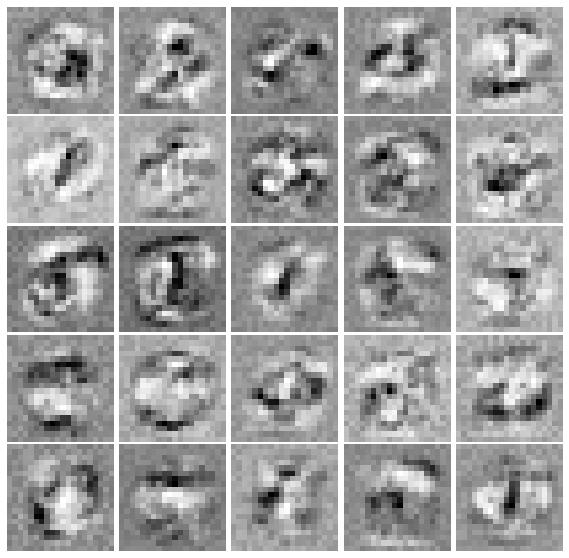

In [223]:
displayData(theta1_opt[:, 1:])